In [2]:
from fastai.vision import *
from fastai.layers import *
from fastai.callbacks import *
from fastai.callbacks.mem import *
from fastai.callbacks.hooks import *
import fastai.utils
import re
import cv2
import torch
import warnings
warnings.filterwarnings('ignore')

In [4]:
train_csv_path = './train.csv'
train_data_path = './train_images'
test_csv_path = './test.csv'
test_data_path = './test_images'
unicode_csv_path = './unicode_translation.csv'

In [5]:
def _binarize(x):
    if x.shape[0] != 1:
        b = x.shape[1]
        b = b if b % 2 == 1 else b+1
        x = cv2.cvtColor(x.numpy().transpose(1, 2, 0), cv2.COLOR_BGR2GRAY)
        x = (x*255).astype('uint8')
        x = cv2.adaptiveThreshold(x,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,b,2)
        x = torch.from_numpy(x/255).float()
        x = torch.unsqueeze(x, 0)
    return x
                           
binarize = TfmPixel(_binarize)

In [6]:
def filter_too_many(filename):
    # Takes the filename, checks if the last number is < 500, since that is the nth sample
    num = filename.parts[-1].split('_')[-1].split('.')[0]
    return int(num) < 500

In [24]:
# Use for total data
db = ImageList.from_folder('./char_images') \
            .filter_by_func(filter_too_many) \
            .use_partial_data(0.3) \
            .split_by_rand_pct(0.3) \
            .label_from_folder() \
            .transform([[binarize()], [binarize()]], size=(32,32)) \
            .databunch(bs=16) \
            .normalize()

In [25]:
db.save('30pct32sz16bsN_db')

In [7]:
db = load_data('./char_images','30pct32sz16bsN_db')

In [8]:
loss = nn.CrossEntropyLoss()

class KuzuCharRec(nn.Module):
    
    def _conv2d_layer(self, ni, nf, stride=1):
        return nn.Sequential(
            conv2d(ni, nf, stride=stride, padding=1, bias=True),
            relu(True),
            batchnorm_2d(nf)
        )
    
    def __init__(self):
        super().__init__()
        starting_channels = 128
        self.conv_layers = []
        ch = starting_channels
        for i in range(0,9):
            if i%3 == 0:
                if i == 0:
                    self.conv_layers.append(self._conv2d_layer(1, ch, stride=2))
                else:
                    self.conv_layers.append(self._conv2d_layer(ch, ch*2, stride=2))
                    ch *= 2
            else:
                self.conv_layers.append(self._conv2d_layer(ch, ch))
        self.conv_layers = nn.Sequential(*self.conv_layers)
        self.pool1 = PoolFlatten()
        self.lin = nn.Sequential(*bn_drop_lin(ch, db.c, p=0.2))
        
    def forward(self, xb):
        act1 = self.conv_layers(xb)
        act2 = self.pool1(act1)
        act3 = self.lin(act2)
        return act3

In [9]:
learn = Learner(db, KuzuCharRec(), metrics=error_rate)
learn.summary()

KuzuCharRec
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [128, 16, 16]        1,280      True      
______________________________________________________________________
ReLU                 [128, 16, 16]        0          False     
______________________________________________________________________
BatchNorm2d          [128, 16, 16]        256        True      
______________________________________________________________________
Conv2d               [128, 16, 16]        147,584    True      
______________________________________________________________________
ReLU                 [128, 16, 16]        0          False     
______________________________________________________________________
BatchNorm2d          [128, 16, 16]        256        True      
______________________________________________________________________
Conv2d               [128, 16, 16]        147,584    True      
__________________________________________________

In [10]:
gc.collect()
db

ImageDataBunch;

Train: LabelList (536079 items)
x: ImageList
Image (1, 32, 32),Image (1, 32, 32),Image (1, 32, 32),Image (1, 32, 32),Image (1, 32, 32)
y: CategoryList
U+3089,U+795F,U+7E2E,U+5B0B,U+308A
Path: char_images;

Valid: LabelList (229747 items)
x: ImageList
Image (1, 32, 32),Image (1, 32, 32),Image (1, 32, 32),Image (1, 32, 32),Image (1, 32, 32)
y: CategoryList
U+620C,U+6309,U+3082,U+5949,U+808C
Path: char_images;

Test: None

In [10]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


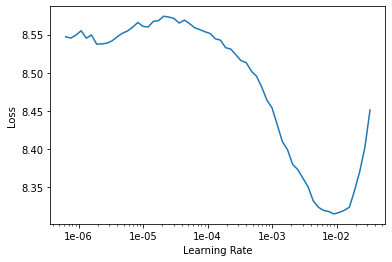

In [11]:
learn.recorder.plot(skip_end=20)

In [12]:
learn.fit_one_cycle(7, slice(1e-3), callbacks=[SaveModelCallback(learn,every='epoch', name='30pct32sz16bsN_model')])

epoch,train_loss,valid_loss,error_rate,time
0,1.139723,0.959465,0.176947,1:23:13
1,0.509951,0.411166,0.088741,06:39
2,0.274997,0.241643,0.052227,04:04
3,0.150866,0.155999,0.033328,04:07
4,0.067014,0.108880,0.022507,04:04
5,0.012257,0.087478,0.017593,04:05
6,0.003351,0.083871,0.016875,04:10


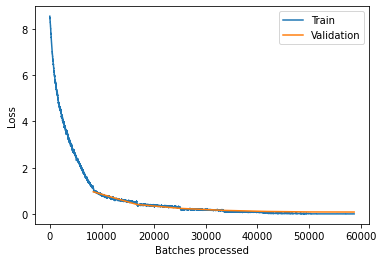

In [13]:
learn.recorder.plot_losses()

In [11]:
learn.load('30pct32sz16bsN_model_6')

Learner(data=ImageDataBunch;

Train: LabelList (536079 items)
x: ImageList
Image (1, 32, 32),Image (1, 32, 32),Image (1, 32, 32),Image (1, 32, 32),Image (1, 32, 32)
y: CategoryList
U+3089,U+795F,U+7E2E,U+5B0B,U+308A
Path: char_images;

Valid: LabelList (229747 items)
x: ImageList
Image (1, 32, 32),Image (1, 32, 32),Image (1, 32, 32),Image (1, 32, 32),Image (1, 32, 32)
y: CategoryList
U+620C,U+6309,U+3082,U+5949,U+808C
Path: char_images;

Test: None, model=KuzuCharRec(
  (conv_layers): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 

In [78]:
interp = ClassificationInterpretation.from_learner(learn)

RuntimeError: [enforce fail at CPUAllocator.cpp:64] . DefaultCPUAllocator: can't allocate memory: you tried to allocate 3870777456 bytes. Error code 12 (Cannot allocate memory)


In [57]:
img = db.train_ds[1][0]
pred, _, _ = learn.predict(img)

In [58]:
db.y.classes[pred.data.item()]

'U+795F'

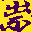

In [59]:
img

In [60]:
xb, y = next(iter(db.train_dl))

In [61]:
xb_sing = Image(xb[0])

In [62]:
m = learn.model.eval()

In [63]:
def get_hook(xb):
    with hook_output(m.conv_layers) as hook:
        p = m(xb)
        return hook

In [64]:
hk = get_hook(xb)

In [65]:
kern = hk.stored[0].cpu()
kern.shape

torch.Size([512, 4, 4])

In [66]:
avg_acts = kern.mean(0)
avg_acts.shape

torch.Size([4, 4])

In [75]:
def show_heatmap(hm):
    _,ax = plt.subplots()
    img.show(ax, cmap='gray')
    ax.imshow(hm, alpha=0.7, extent=(0,32,32,0), interpolation='spline36', cmap='winter');

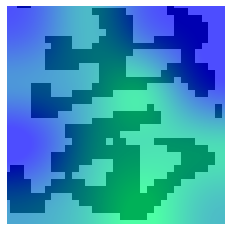

In [76]:
show_heatmap(avg_acts)